In [0]:
# Load in one of the tables
df = spark.sql("select * from default.reviews_train")
print((df.count(), len(df.columns)))

(3138710, 11)


In [0]:
from pyspark.sql.functions import isnan, when, count, col
df_test = df.drop("verified")
df_test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_test.columns]).show()

+--------+-------+----------+----------+----+------------+----------+-------+--------------+-----+
|reviewID|overall|reviewTime|reviewerID|asin|reviewerName|reviewText|summary|unixReviewTime|label|
+--------+-------+----------+----------+----+------------+----------+-------+--------------+-----+
|       0|      0|         0|         0|   0|         539|         0|    371|             0|    0|
+--------+-------+----------+----------+----+------------+----------+-------+--------------+-----+



In [0]:
df.printSchema()

root
 |-- reviewID: integer (nullable = true)
 |-- overall: double (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)
 |-- label: integer (nullable = true)



In [0]:
# Let's look at some quick summary statistics
df.withColumnRenamed('summary', 'summaryCol').describe().show()

+-------+-----------------+------------------+----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+
|summary|         reviewID|           overall|reviewTime|          reviewerID|                asin|reviewerName|          reviewText|          summaryCol|      unixReviewTime|              label|
+-------+-----------------+------------------+----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+
|  count|          3138710|           3138710|   3138710|             3138710|             3138710|     3138480|             3138710|             3138339|             3138710|            3138710|
|   mean|        1569355.5| 4.319868034957037|      null|                null| 4.429350743222517E7|         NaN| 7.852610784558824E7|            Infinity|1.3923188409546597E9|0.17951674414010851|
| stddev|906067.6760

In [0]:
# The count of each overall rating

from pyspark.sql.functions import col
test = df.groupBy("overall", "label").count().orderBy(col("overall").asc()).show()

+-------+-----+-------+
|overall|label|  count|
+-------+-----+-------+
|    1.0|    0|  90685|
|    1.0|    1|  70565|
|    2.0|    1|  45216|
|    2.0|    0|  92570|
|    3.0|    1|  63136|
|    3.0|    0| 199491|
|    4.0|    0| 448904|
|    4.0|    1| 102221|
|    5.0|    0|1743609|
|    5.0|    1| 282313|
+-------+-----+-------+



In [0]:
# The most common product IDs
df.groupBy("asin").count().orderBy(col("count").desc()).show(10)

+----------+-----+
|      asin|count|
+----------+-----+
|0007420412|17660|
|000711835X|16598|
|0007548672|14316|
|0007350899| 7155|
|0007444117| 7058|
|B000YGEVMI| 6621|
|0007378033| 5695|
|B0015TMHSI| 5294|
|006017322X| 4674|
|0007384289| 4574|
+----------+-----+
only showing top 10 rows



In [0]:
# For our intitial modeling efforts, we are not going to use the following features
drop_list = ['reviewID', 'image', 'style']
df = df.select([column for column in df.columns if column not in drop_list])
print((df.count(), len(df.columns)))

(3138710, 10)


In [0]:
df = df.na.fill(value="This review does not have a summary or title",subset=["summary"])

In [0]:
df = df.na.drop(subset=["reviewText", "label"])
df.show(5)
print((df.count(), len(df.columns)))

+-------+--------+-----------+--------------+----------+---------------+--------------------+--------------------+--------------+-----+
|overall|verified| reviewTime|    reviewerID|      asin|   reviewerName|          reviewText|             summary|unixReviewTime|label|
+-------+--------+-----------+--------------+----------+---------------+--------------------+--------------------+--------------+-----+
|    5.0|    true|10 17, 2015|A1HP7NVNPFMA4N|0700026657|    Ambrosia075|This game is a bi...|but when you do i...|    1445040000|    0|
|    5.0|   false|03 30, 2005|A1REUF3A1YCPHM|0001713353|    TW Ervin II|The King, the Mic...|A story children ...|    1112140800|    0|
|    5.0|    true| 11 5, 2015| A8LUWTIPU9CZB|0560467893|   Linda Fahner|Great product, lo...|          Five Stars|    1446681600|    0|
|    5.0|    true|06 20, 2016| AVP0HXC9FG790|0001713353|Amazon Customer|  The kids loved it!|          Five Stars|    1466380800|    0|
|    3.0|    true| 05 7, 2015|A3B6GKQQ1JJ167|056

In [0]:
df.printSchema()

root
 |-- overall: double (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = false)
 |-- unixReviewTime: integer (nullable = true)
 |-- label: integer (nullable = true)



In [0]:
df.groupBy("label").count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1| 563451|
|    0|2575259|
+-----+-------+



In [0]:
from pyspark.sql.functions import first, year, month, datediff, to_date, col, length

df = df.withColumn("lengthOfReviewerName", length(col("reviewerName")))
df = df.fillna(0, subset=["lengthOfReviewerName"])

In [0]:
from pyspark.sql.functions import from_unixtime, unix_timestamp, row_number, desc
from pyspark.sql.window import Window


df = df.withColumn("review_time", from_unixtime("unixReviewTime"))
# Define a window specification to partition by 'asin' and order by 'review_time'
window_spec = Window.partitionBy("asin").orderBy(desc("review_time"))
df = df.withColumn("year", year("review_time"))
df = df.withColumn("month", month("review_time"))
# Add a new column 'review_order' that assigns a sequential order to reviews within each 'asin' group
df = df.withColumn("reviewOrder", row_number().over(window_spec))

windowSpec = Window.partitionBy("asin").orderBy("unixReviewTime")

df = df.withColumn("first_unixReviewTime", first("unixReviewTime").over(windowSpec))

# Calculate the days since the first review
df= df.withColumn("daysincefirstreview", (col("unixReviewTime") - col("first_unixReviewTime")) / 86400)


# Show the updated DataFrame
df = df.drop("unixReviewTime", "review_time", "first_unixReviewTime")

df.show(truncate=10)

+-------+--------+----------+----------+----------+------------+----------+----------+-----+--------------------+----+-----+-----------+-------------------+
|overall|verified|reviewTime|reviewerID|      asin|reviewerName|reviewText|   summary|label|lengthOfReviewerName|year|month|reviewOrder|daysincefirstreview|
+-------+--------+----------+----------+----------+------------+----------+----------+-----+--------------------+----+-----+-----------+-------------------+
|    4.0|   false|12 22, ...|A3DFH4C...|0001384198|  Suzanne...|If I we...|A real ...|    0|                  13|1999|   12|        412|                0.0|
|    5.0|   false|01 11, ...|ABMBUSA...|0001384198|  Jason Shaw|Even as...|Wonderf...|    1|                  10|2000|    1|        411|               20.0|
|    5.0|   false|07 23, ...|ATDE9JY...|0001384198|  Alyssa ...|Few boo...|Breaks ...|    1|                  16|2001|    7|        410|              579.0|
|    4.0|   false|08 22, ...|A3FHSLW...|0001384198|  Eliza

In [0]:
from pyspark.sql.functions import hash

df = df.withColumn("asinHashing", hash("asin"))
df = df.withColumn("reviewerIDHashing", hash("reviewerID"))


In [0]:
from pyspark.sql.functions import col, avg, split, size

average_ratings = df.groupBy('asin').agg(avg(col('overall')).alias('average_rating_asin'))

# Merge the average ratings and word counts back into the original DataFrame
df = df.join(average_ratings, 'asin', 'left')

In [0]:
from pyspark.sql.functions import length
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import re

def count_sentences(text):
    return len(re.split(r'[.!?]', text))  # Regex to split text based on sentence delimiters

count_sentences_udf = udf(count_sentences, IntegerType())

def count_words(text):
    words = text.split()
    return len(words)

# Register the UDF
count_words_udf = udf(count_words, IntegerType())

def summary_length(text):
    if (text == "This review does not have a summary or title"):
        return 0
    else:
        return len(text)

# Register the UDF
summary_length_udf = udf(summary_length, IntegerType())

# Apply the UDF to count sentences
def sentencecountratio(df):
    
    df_test1 = df.withColumn('text_length', F.coalesce(length('reviewText'),F.lit(0)))
    df_test2 = df_test1.withColumn("sentence_count", F.coalesce(count_sentences_udf("reviewText"), F.lit(1)))
    df_test3 = df_test2.withColumn("sentence_length_ratio", (df_test2["text_length"]/df_test2["sentence_count"]))
    df_test4 = df_test3.withColumn("overall_sentence_length_ratio", (df_test3["text_length"]*df_test3["overall"]))
    df_test5 = df_test4.withColumn("word_count", count_words_udf(df["reviewText"]))
    df_test6 = df_test5.withColumn('summary_length', summary_length_udf("summary"))
    return df_test6

df = sentencecountratio(df)

In [0]:
from pyspark.sql.functions import udf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()
from textblob import TextBlob
from pyspark.sql.types import DoubleType

def rescale_udf(value):
    # Assuming value is in the range [-1, 1]
    return (value + 1) / 2.0

sentiment_polarity_udf = udf(lambda x: TextBlob(x).sentiment[0]) 
sentiment_subj_udf = udf(lambda x: TextBlob(x).sentiment[1])
rescale = udf(rescale_udf, DoubleType())

def sentimentanalyzer(df):
    df_test1 = df.withColumn("polarity_review",sentiment_polarity_udf("reviewText").cast("double"))
    df_test2 = df_test1.withColumn("subjectivity_review",sentiment_subj_udf("reviewText").cast("double"))
    df_test3 = df_test2.withColumn("polarity_summary",sentiment_polarity_udf("summary").cast("double"))
    df_test4 = df_test3.withColumn("subjectivity_summary",sentiment_subj_udf("summary").cast("double"))
    df_test5 = df_test4.withColumn("sentiment_review", rescale(col("polarity_review")))
    df_test6 = df_test5.withColumn("sentiment_summary", rescale(col("polarity_summary")))
    df_test7 = df_test6.drop("polarity_review","polarity_summary")
    return df_test7

In [0]:
df = sentimentanalyzer(df)

In [0]:
# set seed for reproducibility
(trainingData, testingData) = df.randomSplit([0.9, 0.1], seed = 47)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testingData.count()))

Training Dataset Count: 2825161
Test Dataset Count: 314136


In [0]:
# In Spark's MLLib, it's considered good practice to combine all the preprocessing steps into a pipeline.
# That way, you can run the same steps on both the training data, and testing data and beyond (new data)
# without copying and pasting any code.

# It is possible to run all of these steps one-by-one, outside of a Pipeline, if desired. But that's
# not how I am going to do it here.

#from sparknlp.base import DocumentAssembler, Finisher
#from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, Stemmer

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer, PCA
from pyspark.ml.feature import Word2Vec, CountVectorizer, IDF, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from synapse.ml.lightgbm import LightGBMClassifier
from pyspark.ml.feature import MinMaxScaler

regexTokenizer_review = RegexTokenizer(inputCol="reviewText", outputCol="words_review", pattern="\\W")
regexTokenizer_summary = RegexTokenizer(inputCol="summary", outputCol="words_summary", pattern="\\W")

# Remove standard Stopwords
stopwordsRemover_review = StopWordsRemover(inputCol="words_review", outputCol="filtered_review")
# Remove standard Stopwords
stopwordsRemover_summary = StopWordsRemover(inputCol="words_summary", outputCol="filtered_summary")

word2vec_review = Word2Vec(vectorSize=150, seed=47, inputCol="filtered_review", outputCol="word2vec_review")
word2vec_summary = Word2Vec(vectorSize=50, seed=47, inputCol="filtered_summary", outputCol="word2vec_summary")

assembler = VectorAssembler(inputCols=["year", "month", "asinHashing", "reviewerIDHashing", "lengthOfReviewerName", "verified", "average_rating_asin", "overall", 'text_length', "sentence_count", "word_count", "summary_length", "sentiment_review", "sentiment_summary", "subjectivity_review", "subjectivity_summary", "daysincefirstreview", "word2vec_review", "word2vec_summary"], outputCol="all_features")

#pca = PCA(k=100, inputCol="all_features", outputCol="features")

pipeline = Pipeline(stages=[regexTokenizer_review, regexTokenizer_summary, stopwordsRemover_review, stopwordsRemover_summary, word2vec_review, word2vec_summary, assembler])

In [0]:
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(trainingData)
trainingDataTransformed = pipelineFit.transform(trainingData)
testingDataTranformed = pipelineFit.transform(testingData)

In [0]:
# Machine Learning Algorithm

from synapse.ml.lightgbm import LightGBMClassifier

ml_alg = LightGBMClassifier( objective="binary",
                          #isUnbalance=True,
                          learningRate=0.04,
                          maxBin=100,
                          numLeaves=50,
                          featureFraction=0.65,
                          baggingFraction=0.65,
                          numIterations=20000,
                          seed=47,
                          lambdaL1=50,
                          lambdaL2=50,
                          metric="auc",
                          featuresCol="all_features",
                          labelCol="label"
                           )

lgbmModel = ml_alg.fit(trainingDataTransformed)
trainingDataFitted = lgbmModel.transform(trainingDataTransformed)
predictions = lgbmModel.transform(testingDataTranformed)

In [0]:
feature_importances = lgbmModel.getFeatureImportances()

In [0]:
# Original feature names
original_features = ["year", "month", "asinHashing", "reviewerIDHashing", "lengthOfReviewerName", "verified", "average_rating_asin", "overall", 'text_length', "sentence_count", "word_count", "summary_length", "sentiment_review", "sentiment_summary", "subjectivity_review", "subjectivity_summary", "daysincefirstreview",]

# Assuming wordVectors is 100-dimensional and summaryVectors is 50-dimensional
wordVectors_features = [f"word2vec_review_{i}" for i in range(1, 81)]
summaryVectors_features = [f"word2vec_summary_{i}" for i in range(1, 41)]

all_features = original_features + wordVectors_features + summaryVectors_features

feature_name_importance = list(zip(all_features, feature_importances))
sorted_features = sorted(feature_name_importance, key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
        print(f"Feature: {feature}, Importance: {importance}")
# Combine all feature names

Feature: average_rating_asin, Importance: 15655.0
Feature: asinHashing, Importance: 14524.0
Feature: daysincefirstreview, Importance: 12677.0
Feature: year, Importance: 10416.0
Feature: summary_length, Importance: 8067.0
Feature: reviewerIDHashing, Importance: 7528.0
Feature: sentence_count, Importance: 6351.0
Feature: word_count, Importance: 6038.0
Feature: text_length, Importance: 5731.0
Feature: lengthOfReviewerName, Importance: 5097.0
Feature: word2vec_summary_28, Importance: 4904.0
Feature: word2vec_summary_26, Importance: 4810.0
Feature: word2vec_review_43, Importance: 4803.0
Feature: word2vec_review_53, Importance: 4793.0
Feature: word2vec_review_50, Importance: 4719.0
Feature: word2vec_review_46, Importance: 4712.0
Feature: word2vec_summary_10, Importance: 4705.0
Feature: sentiment_review, Importance: 4699.0
Feature: word2vec_summary_24, Importance: 4693.0
Feature: word2vec_review_16, Importance: 4672.0
Feature: word2vec_summary_18, Importance: 4662.0
Feature: word2vec_review_5

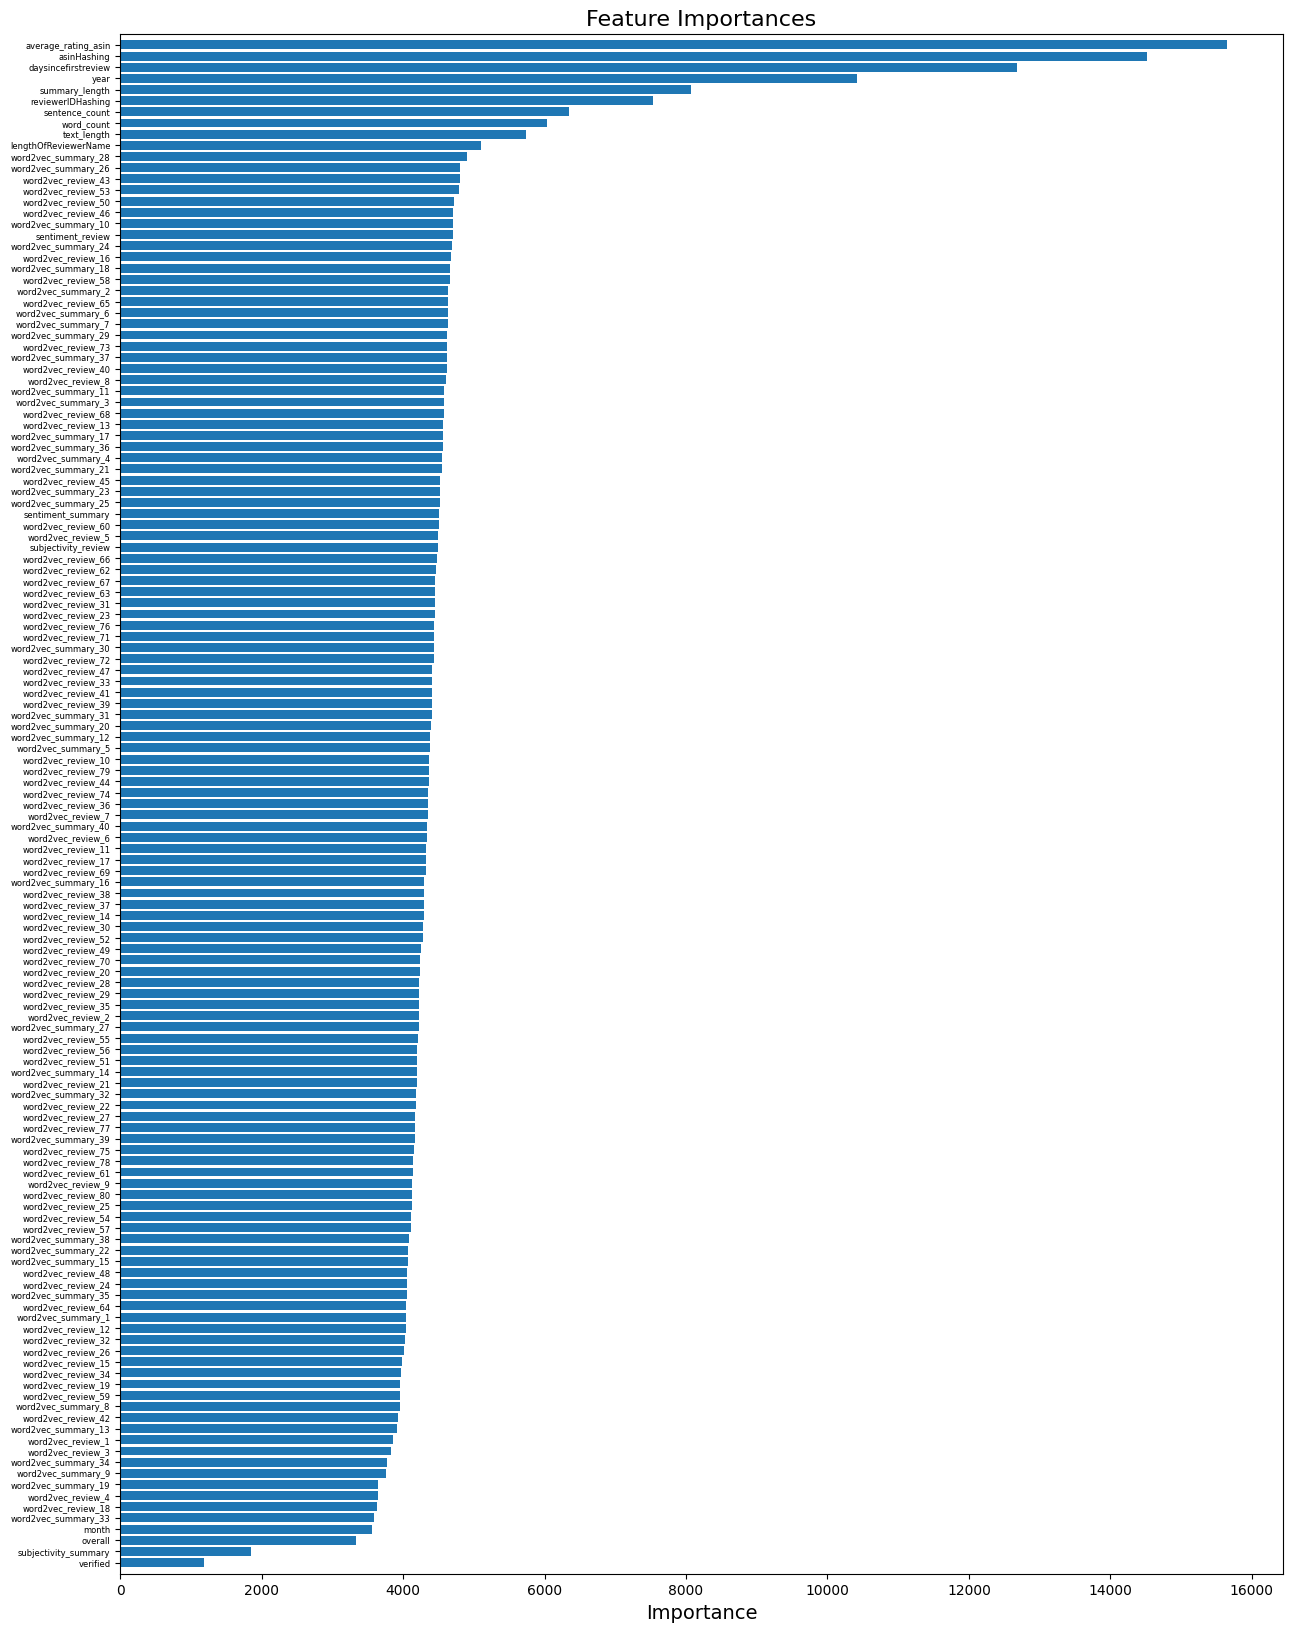

In [0]:
#for fancy plotting
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Assuming sorted_features contains your sorted feature importances
feature_names, importances = zip(*sorted_features)

# Sort by importance
sorted_idx = np.argsort(importances)

# Number of features to plot
N = len(sorted_idx)

# Create a larger plot
plt.figure(figsize=(15, 20))

# Adjust y-axis to fit all labels, adjust font size as needed
plt.yticks(range(N), [feature_names[i] for i in sorted_idx[-N:]], fontsize=6)

# Set Y-axis limits to remove whitespace
plt.ylim([-1, len(sorted_idx)])

# Plot horizontal bar chart
plt.barh(range(N), [importances[i] for i in sorted_idx[-N:]], align='center')
plt.xlabel('Importance', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.show()

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

auc_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

print("Train areaUnderROC    = %g" % (auc_evaluator.evaluate(trainingDataFitted)))
print("Test areaUnderROC   = %g" % (auc_evaluator.evaluate(predictions)))

Train areaUnderROC    = 0.957775
Test areaUnderROC   = 0.957715


In [0]:
test_df = spark.sql("select * from default.reviews_test")

test_df = test_df.na.fill(value="This review does not have a summary or title",subset=["summary"])


test_df = test_df.withColumn("lengthOfReviewerName", length(col("reviewerName")))
test_df = test_df.fillna(0, subset=["lengthOfReviewerName"])

test_df = test_df.withColumn("review_time", from_unixtime("unixReviewTime"))
# Define a window specification to partition by 'asin' and order by 'review_time'
window_spec = Window.partitionBy("asin").orderBy(desc("review_time"))
test_df =  test_df.withColumn("year", year("review_time"))
test_df = test_df.withColumn("month", month("review_time"))
# Add a new column 'review_order' that assigns a sequential order to reviews within each 'asin' group
test_df = test_df.withColumn("reviewOrder", row_number().over(window_spec))

windowSpec = Window.partitionBy("asin").orderBy("unixReviewTime")
test_df = test_df.withColumn("first_unixReviewTime", first("unixReviewTime").over(windowSpec))

# Calculate the days since the first review
test_df = test_df.withColumn("daysincefirstreview", (col("unixReviewTime") - col("first_unixReviewTime")) / 86400)


test_df = test_df.withColumn("asinHashing", hash("asin"))
test_df = test_df.withColumn("reviewerIDHashing", hash("reviewerID"))

average_ratings = test_df.groupBy('asin').agg(avg(col('overall')).alias('average_rating_asin'))

# Merge the average ratings and word counts back into the original DataFrame
test_df = test_df.join(average_ratings, 'asin', 'left')

test_df = test_df.drop("reviewTime", "asin", "reviewerID",  "date",  "unixReviewTime", "review_time")

In [0]:
test_df = sentimentanalyzer(test_df)
test_df = sentencecountratio(test_df)
#test_df.show(10)

In [0]:
kaggle_data_transformed = pipelineFit.transform(test_df)
kaggle_pred = lgbmModel.transform(kaggle_data_transformed)
#kaggle_pred.show(5)
kaggle_pred.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|286609|
|       1.0| 62012|
+----------+------+



In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

probelement=udf(lambda v:float(v[1]),FloatType())
submission_data = kaggle_pred.select('reviewID', probelement('probability')).withColumnRenamed('<lambda>(probability)', 'label')

In [0]:
#display(submission_data.select('reviewID', 'label'))

In [0]:
submission_data.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("dbfs:/FileStore/gowsikan_test/df75.csv")